In [1]:
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
from facenet_pytorch import InceptionResnetV1
import cv2
from PIL import Image
from pdb import set_trace
import time
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import io, transform
from tqdm import trange, tqdm
import csv
import glob
import pandas as pd
import numpy as np



In [2]:
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
data_dir = 'cropped_data'
image_datasets = datasets.ImageFolder(data_dir, data_transforms)
dataloaders = torch.utils.data.DataLoader(image_datasets,  
                                          batch_size=8, 
                                          shuffle=True)
dataset_sizes = len(image_datasets)
class_names = image_datasets.classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_names

['daniele_positive_160', 'klara_positive_160', 'negatives_160']

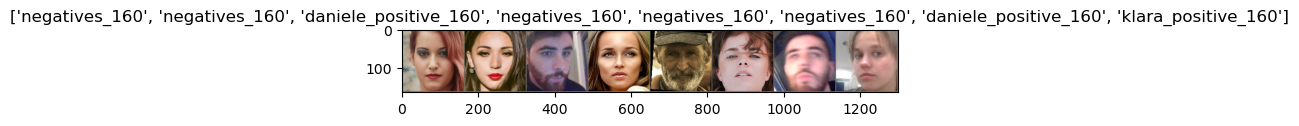

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated# Get a batch of training data
inputs, classes = next(iter(dataloaders))# Make a grid from batch
out = utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [4]:
model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = len(class_names))

model_ft

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [5]:
layer_list = list(model_ft.children())[-5:] # all final layers
layer_list

[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=8631, bias=True)]

In [6]:
class Head(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(in_features=16128, out_features=1024, bias=False)
        self.fc2 = nn.Linear(1024, len(class_names))

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.normalize(x, p=2, dim=1)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

fe = nn.Sequential(*list(model_ft.children())[:-5])
for param in fe.parameters():
    param.requires_grad = False

head = Head().to(device)
finetuned = nn.Sequential(fe, head).to(device)


In [7]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(finetuned.parameters(), lr=0.001, momentum=0.9)

for epoch in range(20):  

    running_loss = 0.0
    running_corrects = 0.0
    for i, data in enumerate(dataloaders, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = finetuned(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    total_loss = running_loss/dataset_sizes
    accuracy = running_corrects/dataset_sizes
    print(f"epoch#{epoch} {total_loss=}   {accuracy=}")

model_path = "finetuned.pt"
print("Saving model "+model_path)
torch.save(finetuned.state_dict(), model_path)

epoch#0 total_loss=0.13454782913385896   accuracy=tensor(0.7285, device='cuda:0')
epoch#1 total_loss=0.12755567471598098   accuracy=tensor(0.8435, device='cuda:0')
epoch#2 total_loss=0.12239505707291123   accuracy=tensor(0.8383, device='cuda:0')
epoch#3 total_loss=0.11786527837496347   accuracy=tensor(0.8435, device='cuda:0')
epoch#4 total_loss=0.11387374351679352   accuracy=tensor(0.8456, device='cuda:0')
epoch#5 total_loss=0.11045072640779723   accuracy=tensor(0.8549, device='cuda:0')
epoch#6 total_loss=0.10749985912303232   accuracy=tensor(0.8580, device='cuda:0')
epoch#7 total_loss=0.10477746064181155   accuracy=tensor(0.8611, device='cuda:0')
epoch#8 total_loss=0.1024085812000413   accuracy=tensor(0.8663, device='cuda:0')
epoch#9 total_loss=0.10025878366411041   accuracy=tensor(0.8632, device='cuda:0')
epoch#10 total_loss=0.09821870648181501   accuracy=tensor(0.8705, device='cuda:0')
epoch#11 total_loss=0.09703301073973661   accuracy=tensor(0.8653, device='cuda:0')
epoch#12 total_

In [18]:
import cv2
from PIL import Image
from facenet_pytorch import MTCNN

model_ft = finetuned

checkpoint = torch.load('finetuned.pt')
model_ft.load_state_dict(checkpoint)

vc = cv2.VideoCapture(0)
model_ft.eval()
mtcnn = MTCNN(image_size=160, margin=0, keep_all=True, min_face_size=40) 

while True:
    ret, frame = vc.read()
    if not ret:
        print("Error reading frame from video capture.")
        break

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_cropped_list, prob_list = mtcnn(frame, return_prob=True) 

    if img_cropped_list is not None:

        boxes, _ = mtcnn.detect(frame)
        for i, prob in enumerate(prob_list):
            if prob>0.90:
                box = boxes[i] 
                custom_frame = img_cropped_list[i].unsqueeze(0).to(device)
                res = model_ft(custom_frame)
                m = torch.argmax(res.detach())
                frame = cv2.rectangle(np.array(frame), (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)
                frame = cv2.putText(frame, class_names[m], (int(box[0]), int(box[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    cv2.imshow("IMG", frame)
    k = cv2.waitKey(1)
    if k%256==27: # ESC
        print('Esc pressed, closing...')
        break

vc.release()
cv2.destroyAllWindows()

Error reading frame from video capture.


[ WARN:0@942.108] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@942.108] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range
